In [1]:
import sys, os
sys.path.append('..')

from Data.TimeSeries import *

from Data.TimeSeries import *
import pandas as pd
import matplotlib

import cvxopt as opt
from cvxopt import blas, solvers

import numpy as np
import zipline
from zipline.api import (add_history, history, set_slippage,
                         slippage, set_commission, commission,
                         order_target_percent, symbol,symbols, record)


from zipline import TradingAlgorithm
from ETF.AAA import AAA
from ML.Features import *
from ML.Targets import *

import matplotlib.pyplot as plt

%matplotlib inline

/Users/jianboxue/anaconda/lib/python2.7/site-packages/pandas/io/data.py:33: FutureWarning: 
The pandas.io.data module is moved to a separate package (pandas-datareader) and will be removed from pandas in a future version.
After installing the pandas-datareader package (https://github.com/pydata/pandas-datareader), you can change the import ``from pandas.io import data, wb`` to ``from pandas_datareader import data, wb``.
  FutureWarning)


In [2]:

class TestNN(AAA) :

    params = {}
    train_win = 0
    nn_win = 0
    ml = 'SVM'
    atr = []
    enable_stoploss = False

    def set_params(self, t_win, n_win, ml='SVM', stoploss=False, rsi=False, vol=False) :
        self.train_win = t_win
        self.nn_win = n_win
        self.ml = ml
        self.atr_len = self.train_win
        self.enable_stoploss = stoploss
        self.enable_RSI = rsi
        self.enable_VOL = vol
        return self

    '''
    Using the last N days price directions as the features
    Target using the next day price direction
    '''
    def create_features(self, df, n = 5) :
        df_target = target_direction(df, 1)
        df_target.columns = ['target']

        list_df_features = []
        for i in xrange(n):
            list_df_features.append(direction(df, i+1))

        df_features = pd.DataFrame()
        for l in list_df_features:
            df_features = df_features.join(l, how='outer')

        if self.enable_RSI:
            df_features['RSI_3'] = ta.RSI(df.values.ravel(), n-1)
            # df_features['RSI_3'] = (ta.RSI(df.values.ravel(), n) > 50) * 1

        if self.enable_VOL:
            df_features['Std'] = pd.rolling_std(df, n-1)

        # adding the target
        df_features = df_features.join(df_target, how='outer')
        #df_features.dropna(inplace=True)

        return df_features.iloc[:, :-1], df_features.iloc[:, [-1]]

    def initialize(self, context):
        add_history(200, '1d', 'price')
        set_slippage(slippage.FixedSlippage(spread=0.0))
        set_commission(commission.PerShare(cost=0.01, min_trade_cost=1.0))
        context.tick = 0

        dp_data = self.data
        df_data = pd.DataFrame(index=dp_data.axes[1])
        df_data['close'] = dp_data[:, :, 'close']
        df_data['open'] = dp_data[:, :, 'open']
        df_data['high'] = dp_data[:, :, 'high']
        df_data['low'] = dp_data[:, :, 'low']
        df_data['volume'] = dp_data[:, :, 'volume']

        self.atr = atr_per_close(df_data, atrLen = self.atr_len)
        context.longstop = 0

    def handle_data(self, context, data):

        context.tick += 1
        total_window = self.train_win + self.nn_win + 1

        if context.tick < (total_window):
            return

        try :
#             print 'tick = {t}'.format(t = context.tick)
            price = history(total_window - 1, '1d', 'price').dropna()
            df_price = pd.DataFrame(data=price.values, index=price.index, columns=['close'])

            features, target = self.create_features(df_price, self.nn_win)
            features_insample = features.iloc[(self.nn_win -1):-1, :].values
            target_insample = target.iloc[(self.nn_win -1):-1, :].values.ravel()

            features_oosample = features.iloc[-1, :]
            features_oosample = features_oosample.values.reshape([1, len(features_oosample)])

            ATR = self.atr.loc[price.index[-1], :][0]

            symbol = price.columns[0]


            if self.enable_stoploss:
                if data[symbol].price < context.longstop:
                    print 'Stop Loss '
                    order_target_percent(symbol, 0.0)
                    context.longstop = 0.0
                    return

            if self.ml == 'SVM' :
                ### Training the SVM
                from sklearn import svm
                model_svm = svm.SVC()
                model_svm.fit(features_insample, target_insample)

                preds_svm = model_svm.predict(features_oosample)[0]
                if preds_svm < 0.5:
                    #print "Sell "
                    order_target_percent(symbol, 0.0)
                    context.longstop = 0.0

                else :
                    #print "Buy"
                    order_target_percent(symbol, 1.0)
                    context.longstop = max(context.longstop, data[symbol].price * (1 - 0.7*ATR))
                    print "target sl = {n}".format(n=context.longstop)

            if self.ml == 'KNN' :
                ### Training the SVM
                from sklearn import neighbors
                k = 10

                model_knn = neighbors.KNeighborsClassifier(k, 'distance')
                model_knn.fit(features_insample, target_insample)

                preds_knn = model_knn.predict(features_oosample)[0]

                if preds_knn < 0.5:
                    #print "Sell "
                    order_target_percent(symbol, 0.0)
                else :
                    #print "Buy"
                    order_target_percent(symbol, 1.0)

            record('price', data[symbol]['price'])
        except :
            pass


In [146]:
class ML :
    params = {}
    data = {}
    ml_model = None
    
    def __init__(self, params):
        self.params = params.copy()
        
    def set_params(self, params) :
        pass
    
    def load_features() :
        pass
    
    def train():
        pass
    
    def predict_last():
        pass
    
class ML_NN(ML) :
    def get_features(self, data):
        df = data[['close']]
        neighbor_len = self.params.get('Neighbor_Len')
        rsi_len = self.params.get('Rsi_Len')
        vol_len = self.params.get('Vol_Len')
        
        df_target = target_direction(df, 1)
        df_target.columns = ['target']

        list_df_features = []
        for i in xrange(neighbor_len):
            list_df_features.append(direction(df, i+1))

        df_data = pd.DataFrame()
        for l in list_df_features:
            df_data = df_data.join(l, how='outer')

        if rsi_len is not None:
            df_data['RSI_3'] = ta.RSI(df.values.ravel(), rsi_len)
            # df_features['RSI_3'] = (ta.RSI(df.values.ravel(), n) > 50) * 1

        if vol_len is not None:
            df_data['Std'] = pd.rolling_std(df, vol_len)

        # adding the target
        df_data = df_data.join(df_target, how='outer')
        #df_features.dropna(inplace=True)
    
        df_features_last = df_data.iloc[-1, :-1]
        
        df_data = df_data.dropna()
        df_features = df_data.iloc[:, :-1]
        df_target = df_data.iloc[:, [-1]]
        
        features = df_features.values
        target = df_target.values.ravel()
        features_last = df_features_last.values.reshape([1, len(df_features_last)])
        
        data_output = {'features': features, 'target': target, 'features_last': features_last}

        return data_output
    
    def train(self, features, target):
        model_name = self.params.get('ML_Model')
        if model_name is None:
            print "Please specify a machine learning model"
            return
        
        if model_name == 'KNN' :
            from sklearn import neighbors
            k = 10
            self.ml_model = neighbors.KNeighborsClassifier(k, 'distance')
        if model_name == 'SVM' :
            from sklearn import svm
            self.ml_model = svm.SVC()

        self.ml_model.fit(features, target)
        
        return self
        
    def predict(self, features_oos) :
        preds = self.ml_model.predict(features_oos)
        return preds

class ML_NextRet(ML) :
    def get_features(self, data) :
        pass
    
        

In [154]:
ml = ML_NN({'Neighbor_Len':5, 'Rsi_Len':3, 'Vol_Len':10, 'ML_Model':'KNN'})
data = ml.get_features(df)

features = data.get('features')
target = data.get('target')

ratio_oos = 0.8
length = len(target)
l = ratio_oos*length
features_train = features[:l]
features_test = features[l:]
target_train = target[:l]
target_test = target[l:]

preds = ml.train(features_train, target_train).predict(features_test)
#features.shape
#target.shape

from sklearn.metrics import confusion_matrix, mean_squared_error, accuracy_score, roc_auc_score
print roc_auc_score(preds, target_test)
print 'error = {n}'.format(n=(float(sum(preds == target_test))/len(target_test)))
#preds == target

0.519490800171
error = 0.517571884984


/Users/jianboxue/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/jianboxue/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/jianboxue/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:12: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/jianboxue/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


## Trend-like Indicators 

In [458]:
def DecyclerOsc(df, HPPeriod1=30, HPPeriod2 = 60) :
    nr = len(df)
    Close = df[['close']].values

    alpha1 = (np.cos(0.707*2*np.pi / HPPeriod1) + np.sin(0.707*2*np.pi/ HPPeriod1) - 1) / np.cos(0.707*2*np.pi/HPPeriod1)
    alpha2 = (np.cos(0.707*2*np.pi / HPPeriod2) + np.sin(0.707*2*np.pi/ HPPeriod2) - 1) / np.cos(0.707*2*np.pi/HPPeriod2)

    HP1 = np.zeros(Close.shape)
    HP2 = np.zeros(Close.shape)

    for i in range(nr):
        if i < 2:
            continue
        else :
            HP1[i] = (1 - alpha1/2) * (1-alpha1/2)* (Close[i] - 2*Close[i-1] + Close[i-2]) + \
                    2*(1 - alpha1) * HP1[i-1] - (1 - alpha1) * (1 - alpha1) * HP1[i-2]
            HP2[i] = (1 - alpha2/2) * (1-alpha2/2)* (Close[i] - 2*Close[i-1] + Close[i-2]) + \
                    2*(1 - alpha2) * HP2[i-1] - (1 - alpha2) * (1 - alpha2) * HP2[i-2]
    Decycle = HP2 - HP1
    df_decycle = pd.DataFrame(data = Decycle, index=df.index, columns=['decycle_osc'])
    df_decycle['decycle_hp1'] = HP1
    df_decycle['decycle_hp2'] = HP2
    df_decycle['close'] = Close
    return df_decycle

def Decycler(close, cutoff = 60) :
    alpha1 = (np.cos(2*np.pi/cutoff) + np.sin(2*np.pi/cutoff) - 1) / np.cos(2*np.pi/cutoff)
    close = df[['close']].values
    decycle = np.zeros(close.shape)

    for i in range(len(decycle)) :
        if i < 1:
            continue
        else :
            decycle[i] = (alpha1 / 2) * (close[i] + close[i-1]) + (1-alpha1)*decycle[i-1]

    #df_decycler = pd.DataFrame(data=decycle, index=df.index, columns=['decycler_{i}'.format(i=cutoff)])
    #df_decycler['close'] = df[['close']]
    return decycle

In [491]:
def ZMA(close, period = 100):
    #close = df[['close']].values.ravel()
    a = 2.0 / (1 + period)
    ema = ta.EMA(close, period)
    error = 10000000
    gain = 5
    gain_limit = 5
    best_gain = 0

    zma = np.zeros(close.shape)
    for i in range(len(zma)):
        if i < period - 1:
            continue
        else:

            gain = -gain_limit
            while gain < gain_limit:
                gain += 0.1
                zma[i] = a * (ema[i] + gain*(close[i] - zma[i-1])) + (1-a)*zma[i-1]
                new_error = close[i] - zma[i]
                if np.abs(error) < new_error:
                    error = np.abs(new_error)
                    best_gain = gain

            zma[i] = a * (ema[i] + best_gain*(close[i] - zma[i-1])) + (1-a)*zma[i-1]

#     df_zma = pd.DataFrame(data=zma, index=df.index, columns=['zma_{i}'.format(i=period)])
    return zma


def ALMA(close, period=100) :
    m = np.floor(0.85 * (period - 1))
    s = period  / 6.0
    alma = np.zeros(close.shape)
    w_sum = np.zeros(close.shape)

    for i in range(len(close)):
        if i < period:
            continue
        else:
            for j in range(period):
                w = np.exp(-(j-m)*(j-m)/(2*s*s))
                alma[i] += close[i - period + j] * w
                w_sum[i] += w
            alma[i] = alma[i] / w_sum[i]

#     df_alma = pd.DataFrame(data=alma, index=df.index, columns=['alma_{i}'.format(i=period)])
    return alma


def LowPass(close, period = 100):
    close = df[['close']].values.ravel()
    a = 2.0 / (1+period)
    lp = close.copy()

    for i in range(len(close)) :
        if i < 2:
            continue
        else :
            lp[i] = (a - 0.25*a*a)*close[i] \
                + 0.5*a*a*close[i-1] \
                - (a-0.75*a*a)*close[i-2] \
                + 2*(1.0-a)*lp[i-1] \
                - (1.0 -a)*(1.0 -a)*lp[i-2]
    df_lp = pd.DataFrame(data=lp, index=df.index, columns=['lp_{i}'.format(i=period)])
    return df_lp


def SuperSmooth(close, period=50) :
            
    f = (1.414*np.pi)/period
    a = np.exp(-f)
    c2 = 2 * a * np.cos(f)
    c3 = - a*a
    c1 = 1 - c2 - c3

    ss = np.zeros(close.shape)
    for i in range(len(close)) :
        if i < 2:
            continue
        else :
            ss[i] = c1 * (close[i] + close[i-1])*0.5 + c2*ss[i-1] + c3*ss[i-2] 
#     df_ss = pd.DataFrame(data=ss, index=df.index, columns=['ss_{i}'.format(i=period)])
    return ss


In [740]:
def ExtremePoints(data):
    valley = np.zeros(data.shape)
    peak = np.zeros(data.shape)
    pos_reversal = np.zeros(data.shape)
    pos_trend = np.zeros(data.shape)

    for i in range(len(close)) :
        if i < 1:
            continue
        if i >= (len(close) - 1):
            continue

        if (data[i] > data[i-1]) and (data[i] > data[i+1]) :
            peak[i] = 1
            pos_reversal[i] = 0
            pos_trend[i] = 1
        elif (data[i] < data[i-1]) and (data[i] < data[i+1]) :
            valley[i] = 1
            pos_reversal[i] = 1
            pos_trend[i] = 0
        else :
            pos_reversal[i] = pos_reversal[i-1]
            pos_trend[i] = pos_trend[i-1]
    

    return peak, valley, pos_reversal, pos_trend

def MMI(data, period = 100) :
    mmi = np.zeros(data.shape)
    for i in range(len(data)) :
        if i < period:
            continue
        
        m = np.median(data[(i-period + 1):i])
        nl = 0
        nh = 0
        for j in range(period-1):
            if j < 1:
                continue
            if (data[i-j] > m) and (data[i-j] > data[i-j-1]) :
                nl += 1
            if (data[i-j] < m) and (data[i-j] < data[i-j-1]) :
                nh += 1
        mmi[i] = 100.0 * (nl+nh)/(period -1 )
    return mmi
            
            

period = 60

data = df[['close']].values.ravel()
ret = df[['close']].pct_change().fillna(0).values.ravel()
df_test = df[['close']].copy()

df_test['trend'] = SuperSmooth(data, 5)
df_test['trend'] = ALMA(df_test['trend'].values, period)
p, v, pos_re, pos_tr = ExtremePoints(df_test['trend'].values)


df_test['peak'] = p
df_test['valley'] = v
df_test['pos_re'] = pos_re
df_test['pos_tr'] = pos_tr
df_test['mmi'] = MMI(data, period)
df_test.tail()

,close,trend,peak,valley,pos_re,pos_tr,mmi
Date,,,,,,,
2016-03-16 00:00:00+00:00,203.34,195.131889,0,0,1,0,54.237288
2016-03-17 00:00:00+00:00,204.63,195.704629,0,0,1,0,54.237288
2016-03-18 00:00:00+00:00,204.38,196.293403,0,0,1,0,54.237288
2016-03-21 00:00:00+00:00,204.67,196.893298,0,0,1,0,52.542373
2016-03-22 00:00:00+00:00,204.56,197.487237,0,0,0,0,54.237288


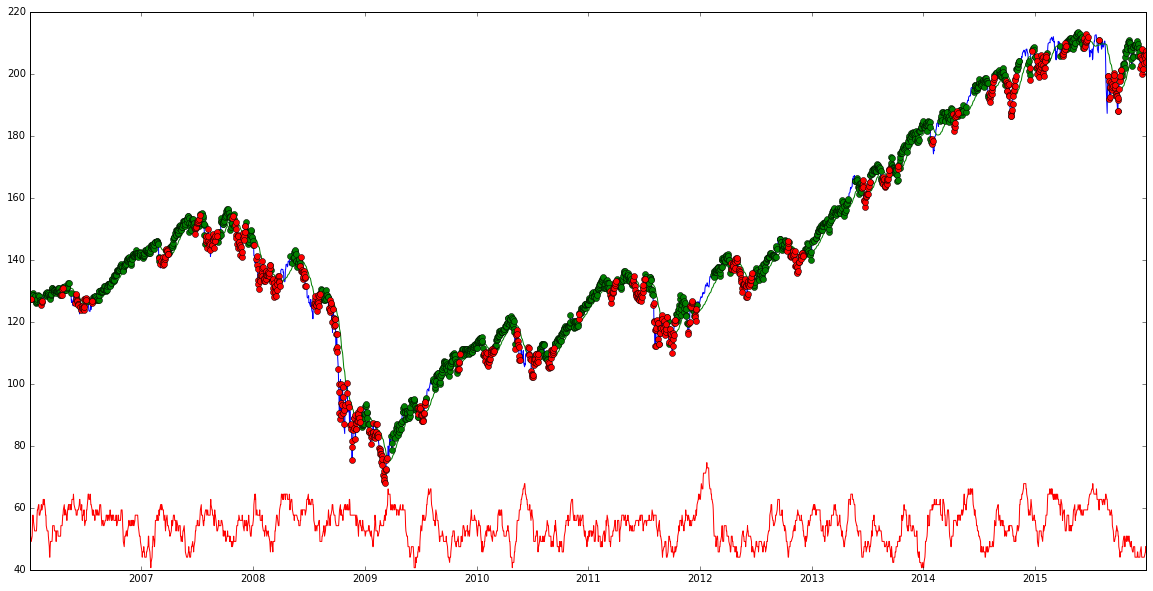

In [746]:
import matplotlib.pyplot as plt
df_test1 = df_test['2006-01-01':'2016-01-01']
plt.figure(figsize=[20, 10])
plt.plot(df_test1['close'])
plt.plot(df_test1['trend'])
plt.plot(df_test1['close'][df_test1['pos_re'].shift(1)==1][df_test1['mmi'] < 60], 'go')
plt.plot(df_test1['close'][df_test1['pos_re'].shift(1)==0][df_test1['mmi'] < 60], 'ro')


# plt.plot(df_test1['close'][df_test1['pos_tr'].shift(1)==1][df_test1['mmi'] > 60], 'go')
# plt.plot(df_test1['close'][df_test1['pos_tr'].shift(1)==0][df_test1['mmi'] > 60], 'ro')


# plt.plot(df_test1['close'][df_test1['valley'].shift(1)==1][df_test1['mmi'] > 60], 'ro')
# plt.plot(df_test1['close'][df_test1['peak'].shift(1)==1][df_test1['mmi'] > 60], 'ro')
# plt.plot(df_test1['close'][df_test1['valley'].shift(1)==1][df_test1['mmi'] > 60], 'go')
plt.plot(df_test1['mmi'])

In [555]:
period = 10
df_trend = df[['close']].copy()
df_trend['trend'] = ALMA(df_trend['close'].values.ravel(), 50)
df_trend['cycle'] = df_trend['close'] - df_trend['trend']
df_trend['trend_e'] = Energy(df_trend['trend'].pct_change().values, period)
df_trend['cycle_e'] = Energy(df_trend['cycle'].pct_change().values, period)

def Energy(data, period) :
    data = data.reshape([len(data), 1])
    energy = np.zeros(data.shape)

    for i in range(len(energy)) :
        if i < period:
            continue

        energy[i] = (data[(i-period+1):i] * data[(i-period+1):i]).sum()
    return energy

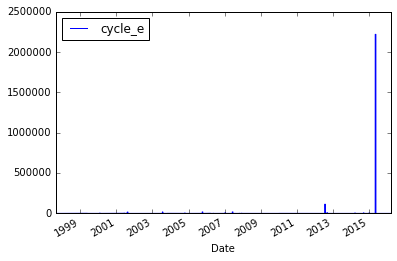

In [559]:
df_trend[['cycle_e']].plot()

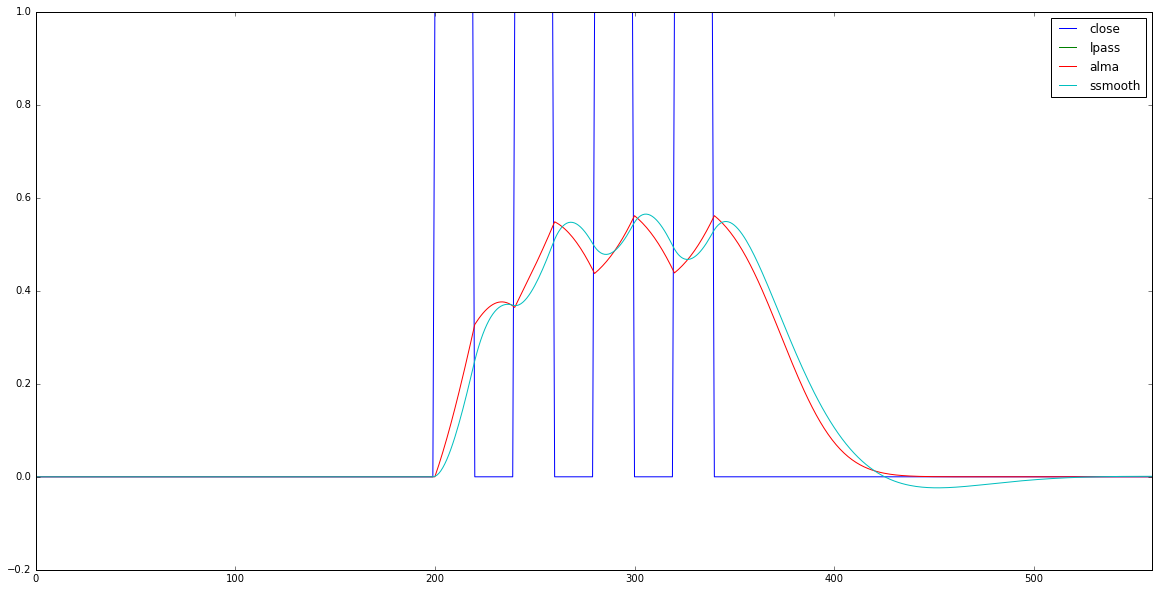

In [504]:
# def ImpluseTest():
period = 150
impluse = np.concatenate((np.zeros([200,1]), np.ones([20,1]), np.zeros([20,1]), np.ones([20,1]), np.zeros([20,1]),np.ones([20,1]), np.zeros([20,1]),np.ones([20,1]), np.zeros([20,1]), np.zeros([200,1])), axis=0)
df_lp = pd.DataFrame(data=impluse, columns=['close'])
df_lp['lpass'] = LowPass(impluse, period)
df_lp['alma'] = ALMA(impluse, period)
# df_lp = df_lp.join(ZMA(df_im, period))
#df_lp['EMA'] = ta.EMA(df_im['close'].values.ravel(), period)
df_lp['ssmooth'] = SuperSmooth(impluse, period)
# df_lp['decycler'] = Decycler(impluse, period)
df_lp.plot(figsize=[20,10])

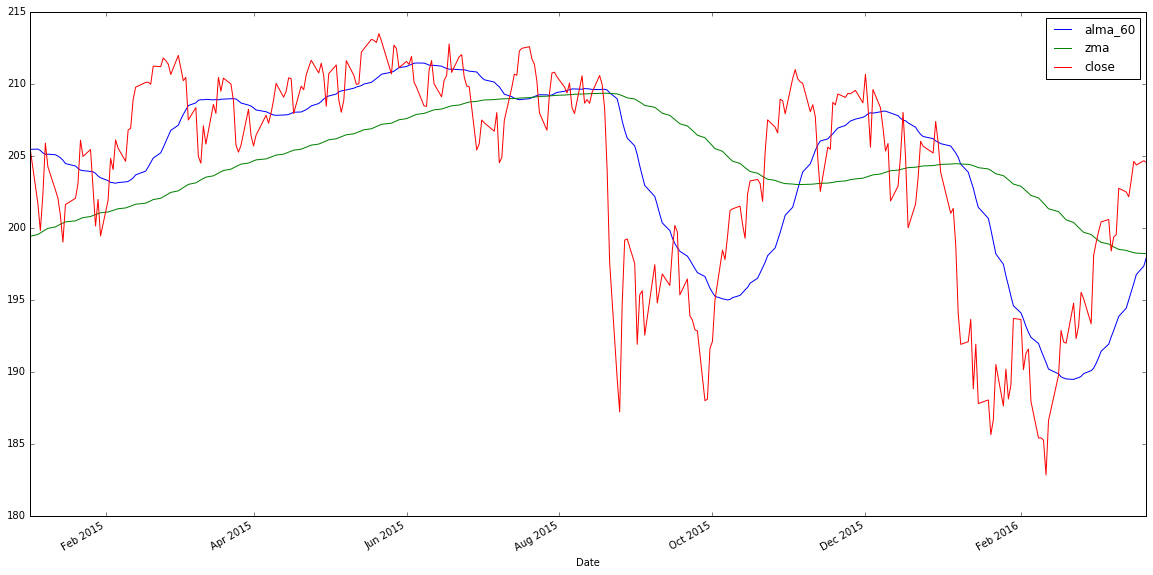

In [361]:
df_alma = ALMA(df, period)
df_alma['zma'] = ZMA(df, period)
df_alma['close'] = df['close']
df_alma['2015-01-01'::].plot(figsize=[20,10])

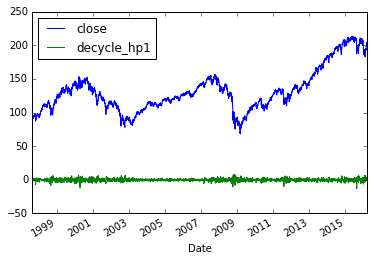

In [324]:
df_decycle_osc = DecyclerOsc(df)
df_decycle_osc[['close', 'decycle_hp1']].plot()

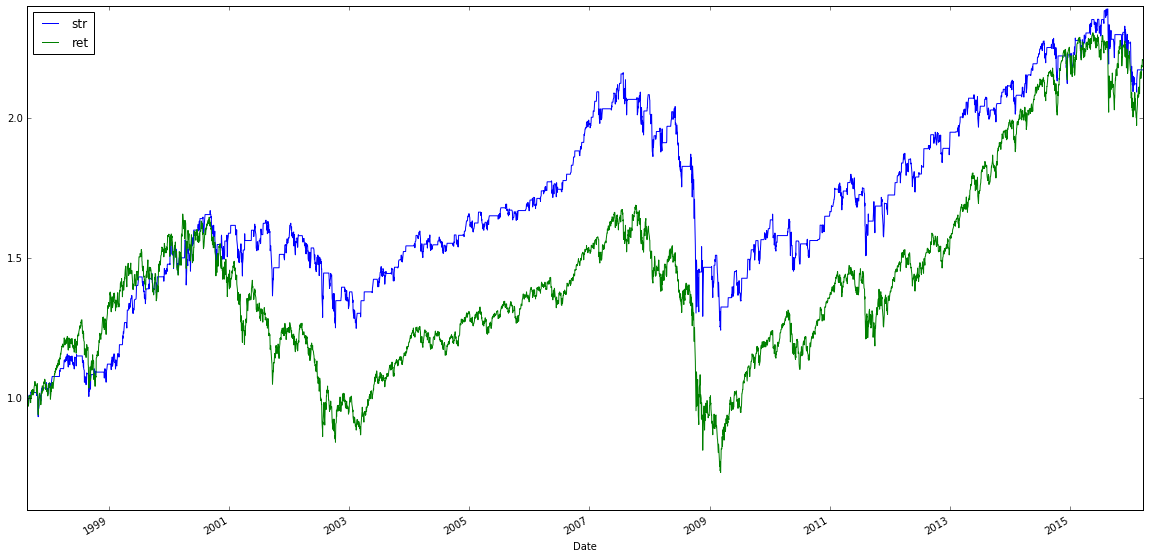

In [301]:
df_de = DecyclerOsc(df, 10, 60)

df_de['ret'] = df[['close']].pct_change()
df_de['str'] = df_de['ret'] * (df_de['decycle_osc'] < 0).shift(1) 
(1+df_de[['str', 'ret']]).cumprod().plot(figsize=[20,10])

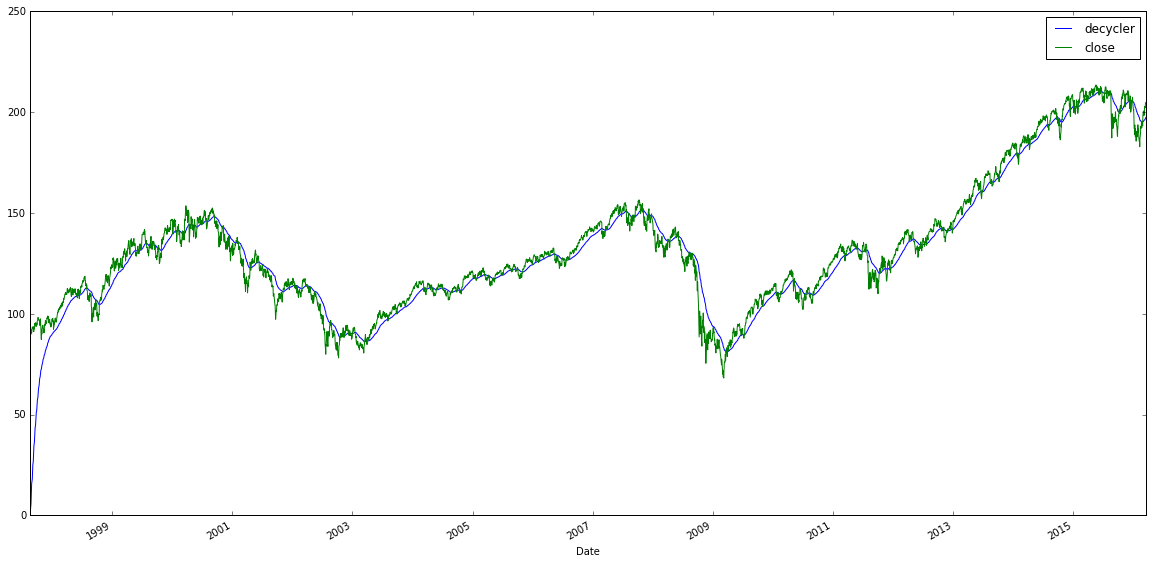

In [322]:
Decycler(df, 200).plot(figsize=[20,10])

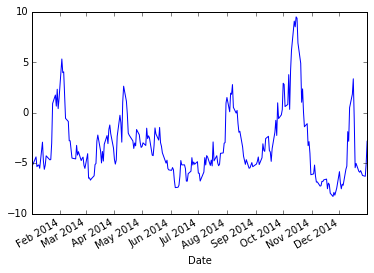

In [311]:
(df_decycle.iloc[:,0] - df_decycle.iloc[:,1])['2014-01-01':'2015-01-01'].plot()

In [219]:
alpha1

-0.33248811797985672

In [182]:
HP2

array([[ 0.],
       [ 0.],
       [ 0.],
       ..., 
       [ 0.],
       [ 0.],
       [ 0.]])

In [70]:
price= df['price'].values
rsi  = ta.RSI(price, 3)
df['rsi'] = rsi
df['sma'] = ta.SMA(price, 3)
df.head()

,open,high,low,close,volume,price,rsi,sma
Date,,,,,,,,
2010-01-01 00:00:00+00:00,112.23,112.65,112.17,111.44,0,111.44,NaN,NaN
2010-01-04 00:00:00+00:00,112.37,113.39,111.51,113.33,118944541,113.33,NaN,NaN
2010-01-05 00:00:00+00:00,113.26,113.68,112.85,113.63,111579866,113.63,NaN,112.800000
2010-01-06 00:00:00+00:00,113.52,113.99,113.43,113.71,116074402,113.71,100,113.556667
2010-01-07 00:00:00+00:00,113.50,114.33,113.18,114.19,131091048,114.19,100,113.843333


In [284]:
if __name__  == "__main__" :
    tickers = ['GOOG/NYSE_SPY']

    settings = Settings()
    dp = TimeSeries(settings).get_agg_ETF_data(tickers)
    dp = dp.fillna(method='pad', axis=0)
    dp = dp.fillna(method='bfill', axis=0)
#     dp = dp[:,'2010-01-01'::,:]
    dp = dp.dropna()
    
    df = pd.DataFrame(index=dp.axes[1])
    for col in dp.axes[2] :
        df[col] = dp[:, :, col]

    dp1 = dp.reindex_axis(['open', 'high', 'low', 'close', 'volume', 'price'], axis=2)

    
#     rets = pd.DataFrame()
#     nn = [2, 5, 10, 20, 50]
#     #nn = [50, 100]
#     for n in nn:
#         print "running {n}".format(n=n)
#         rets['nn={n}'.format(n=n)] = TestNN(dp1).set_params(30, n).run_trading().portfolio_value
#         rets.plot(figsize=[20,12])
    

#     print 'done!'

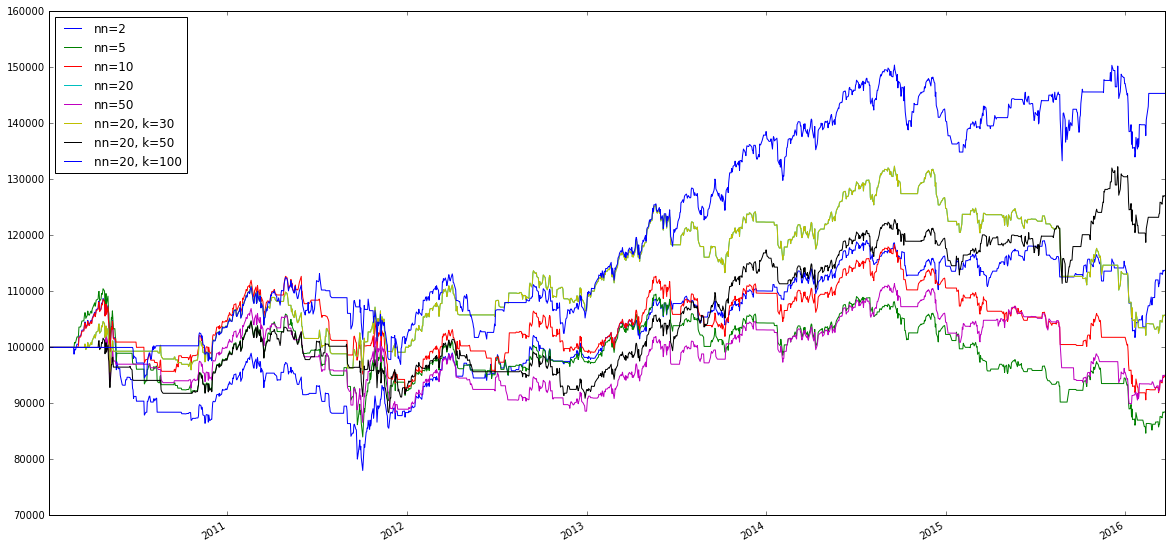

In [3]:
k = [30, 50, 100]
rets['nn=20, k=30'] = rets['nn=20']
rets['nn=20, k=50'] = TestNN(dp1).set_params(50, 20).run_trading().portfolio_value
rets['nn=20, k=100'] = TestNN(dp1).set_params(100, 20).run_trading().portfolio_value

rets.plot(figsize=[20,10])

predict 1.0
predict 1.0
predict 1.0
predict 0.0
predict 0.0
predict 1.0
predict 1.0
predict 0.0
predict 0.0
predict 0.0
predict 0.0
predict 0.0
predict 0.0
predict 0.0
predict 1.0
predict 1.0
predict 0.0
predict 1.0
predict 0.0
predict 0.0
predict 0.0
predict 1.0
predict 1.0
predict 1.0
predict 1.0
predict 0.0
predict 1.0
predict 0.0
predict 1.0
predict 0.0
predict 0.0
predict 0.0
predict 0.0
predict 0.0
predict 1.0
predict 1.0
predict 0.0
predict 0.0
predict 1.0
predict 0.0
predict 1.0
predict 1.0
predict 0.0
predict 0.0
predict 0.0
predict 0.0
predict 0.0
predict 0.0
predict 0.0
predict 1.0
predict 1.0
predict 0.0
predict 1.0
predict 0.0
predict 0.0
predict 0.0
predict 0.0
predict 0.0
predict 0.0
predict 0.0
predict 0.0
predict 0.0
predict 0.0
predict 0.0
predict 0.0
predict 0.0
predict 0.0
predict 0.0
predict 0.0
predict 0.0
predict 0.0
predict 0.0
predict 0.0
predict 0.0
predict 0.0
predict 0.0
predict 0.0
predict 0.0
predict 0.0
predict 0.0
predict 0.0
predict 0.0
predict 0.0
pred

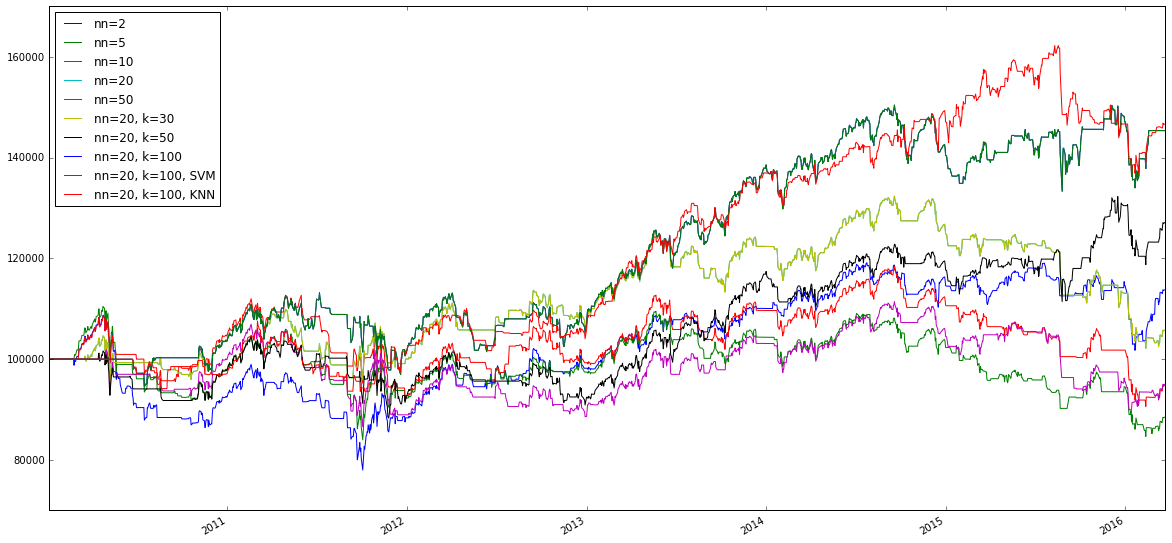

In [15]:
rets['nn=20, k=100, SVM'] = rets['nn=20, k=100']
rets['nn=20, k=100, KNN'] = TestNN(dp1).set_params(100, 20, 'KNN').run_trading().portfolio_value
rets.plot(figsize=[20,10])

In [28]:
NN = [2, 5, 10]
K = [100]
ML = ['SVM', 'KNN']
for n in NN:
    for k in K:
        for m in ML:
            label = 'nn={n}, k={k}, m={m}'.format(n=n, k=k, m=m)
            print label
            rets[label] = TestNN(dp1).set_params(k, n, m).run_trading().portfolio_value


nn=2, k=100, m=SVM
nn=2, k=100, m=KNN
nn=5, k=100, m=SVM
nn=5, k=100, m=KNN
nn=10, k=100, m=SVM
nn=10, k=100, m=KNN


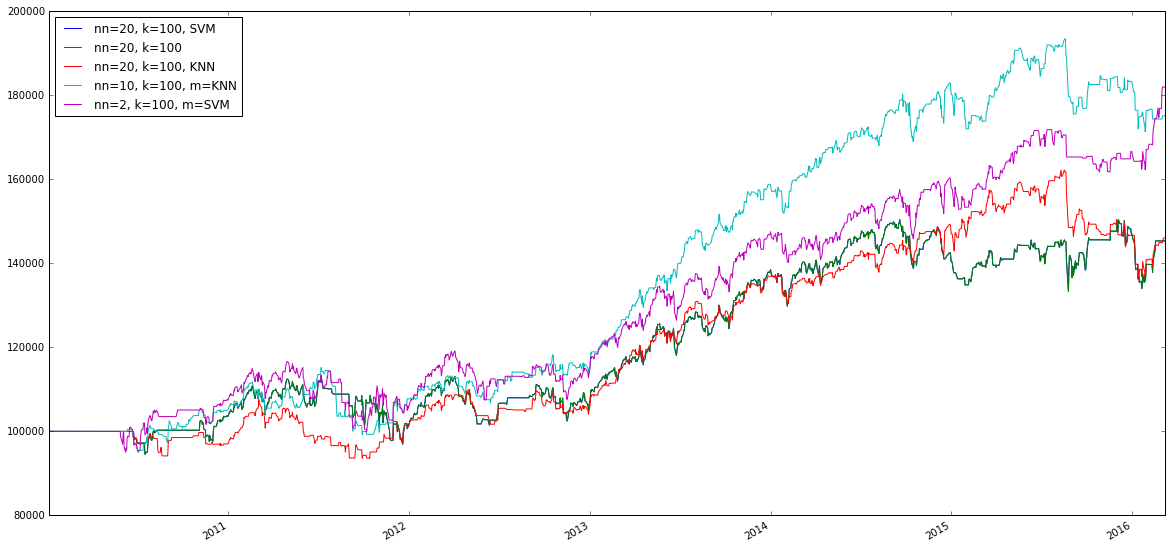

In [72]:
rets = rets.iloc[:-1, :]
max_order = np.argsort(rets.iloc[-1, :].values)
rets.iloc[:, max_order[(len(max_order)-5):]].plot(figsize=[20,10])

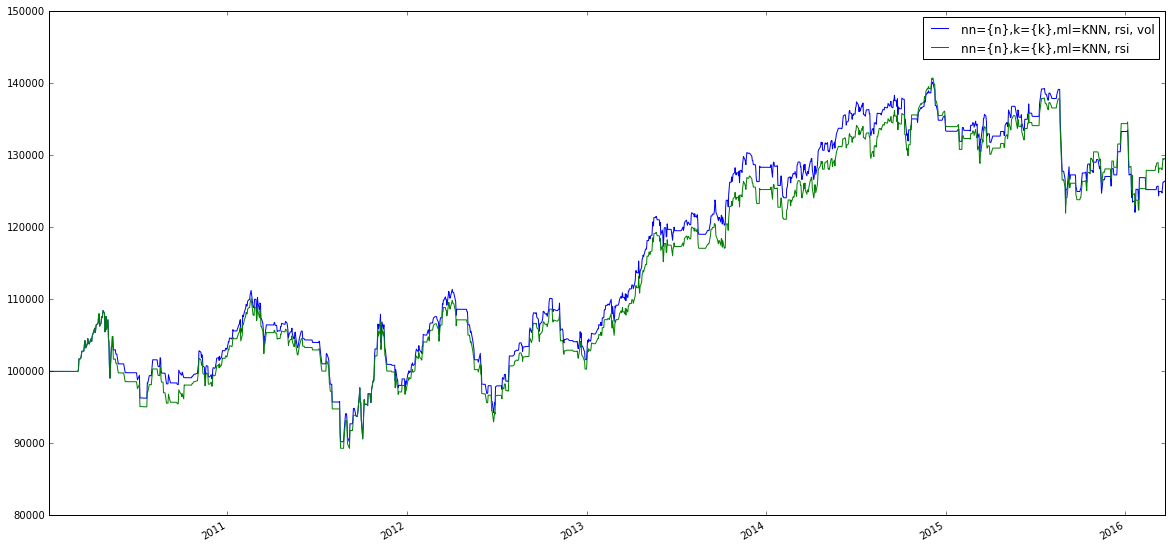

In [4]:
### Test with RSI and Vol
rets_1 = pd.DataFrame()
rets_1['nn={n},k={k},ml=KNN, rsi, vol'] = TestNN(dp1).set_params(30, 10, ml='KNN', rsi=True, vol=True). \
    run_trading().portfolio_value
rets_1['nn={n},k={k},ml=KNN, rsi'] = TestNN(dp1).set_params(30, 10, ml='KNN', rsi=True, vol=False). \
    run_trading().portfolio_value
rets_1.plot(figsize=[20, 10])